In [1]:
import matplotlib.pyplot as plt
import scienceplots

import jax
from datetime import date
import jax.numpy as jnp
import distrax

plt.style.use('science')
#plt.rcParams["axes.spines.right"] = False
#plt.rcParams["axes.spines.top"] = False
#plt.rcParams["figure.figsize"] = (12, 8)

import flax.linen as nn
import jax.scipy.stats as stats

2025-01-29 10:28:52.557747: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-01-29 10:28:52.557814: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2025-01-29 10:28:52.557820: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


Definimos el modelo y la función de verosimilitud

In [2]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X, y = make_moons(noise=0.2, random_state=0, n_samples=1000)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [3]:
X_train.shape

(670, 2)

In [4]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

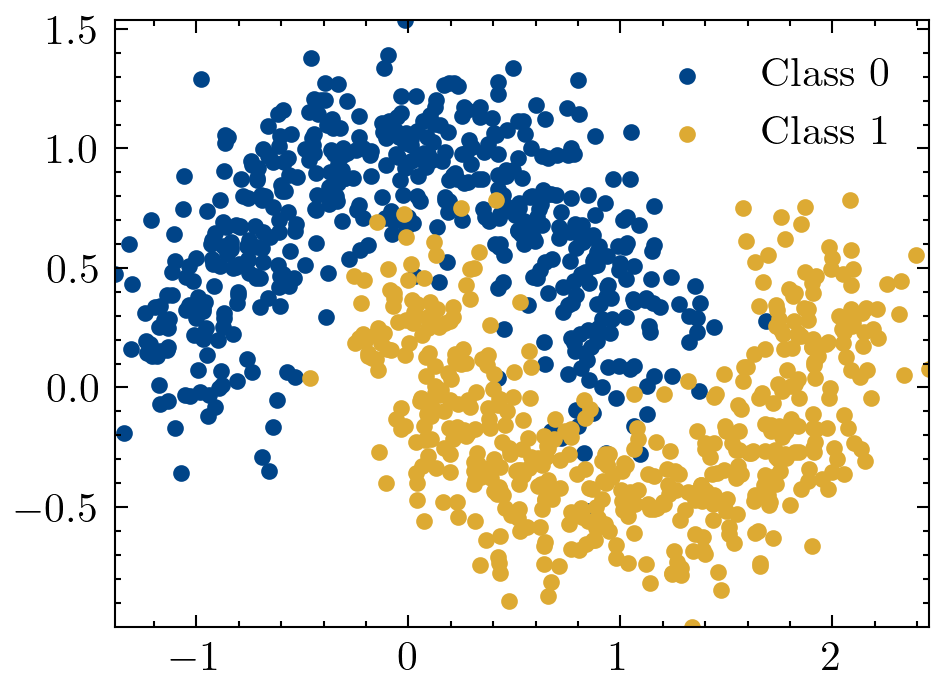

In [5]:
plt.style.use(['science','scatter','high-contrast'])

fig, ax = plt.subplots(dpi=300)
ax.scatter(X[y == 0, 0], X[y == 0, 1], color="C0", label="Class 0")
ax.scatter(X[y == 1, 0], X[y == 1, 1], color="C1", label="Class 1")
ax.autoscale(tight=True)
ax.legend()
#ax.set(xlabel="X1", ylabel="X2", title="Binary classification data set");
#fig.savefig("figures/binary_train_dataset.pdf", dpi=300)
plt.show()
#plt.close()

In [6]:
fig.savefig("binary_train_dataset.pdf", dpi=300)
plt.close()

In [7]:
from sgmcmcjax.kernels import build_sgld_kernel, build_psgld_kernel, build_sgldAdam_kernel, build_sghmc_kernel

class SimpleMLP(nn.Module):

  @nn.compact
  def __call__(self, inputs):
    x = inputs
    x = nn.Dense(32, name=f'layer1')(x)
    x = nn.relu(x)
    x = nn.Dense(64, name=f'layer2')(x)
    x = nn.relu(x)
    x = nn.Dense(1, name=f'layer3')(x)
    x = nn.sigmoid(x)
    return x

model = SimpleMLP()

def logprior(params):
    leaves, _ = jax.tree_util.tree_flatten(params)
    flat_params = jnp.concatenate([jnp.ravel(a) for a in leaves])
    return distrax.Normal(0., 1.).log_prob(flat_params).sum()

def loglikelihood(params, X,y):
    y_pred=model.apply({'params':(params)}, X)
    return distrax.Bernoulli(y_pred).log_prob(y.reshape(-1,1)).sum()


/home/shernandez/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
def run_sgmcmc(key, Nsamples, init_fn, my_kernel, get_params):
    "Run SGMCMC sampler and return the test accuracy list"
    loss = list()
    samples=list()
    key, subkey1,subkey2 = jax.random.split(key,3)
    params = model.init(subkey1, jnp.ones_like(X_train[:2]))['params']
    state = init_fn(subkey2, params)

    for i in range(Nsamples):
        key, subkey = jax.random.split(key)
        state = my_kernel(i, subkey, state)
        loss.append(-1.0*loglikelihood(get_params(state),X_test,y_test))
        position={'params':(get_params(state))}
        samples.append(position)
        if (i%(Nsamples//10)==0):
            print('iteration {0}, loss {1:.2f}'.format(i,loss[-1]))
    return samples,loss


In [9]:
from sgmcmcjax.kernels import build_sgld_kernel, build_psgld_kernel, build_sgldAdam_kernel, build_sghmc_kernel

num_training_steps=1000
mini_batch=64
learning_rate=1e-4

data=(X_train,y_train)
init_fn, sgld_kernel, get_params = build_sgld_kernel(learning_rate, loglikelihood, logprior, data, mini_batch)
sgld_kernel = jax.jit(sgld_kernel)
rng_key = jax.random.PRNGKey(0)


In [10]:
sgld_samples,loss = run_sgmcmc(rng_key, num_training_steps, init_fn, sgld_kernel, get_params)

iteration 0, loss 242.32
iteration 100, loss 193.11
iteration 200, loss 190.25
iteration 300, loss 188.23
iteration 400, loss 186.45
iteration 500, loss 185.40
iteration 600, loss 184.03
iteration 700, loss 184.43
iteration 800, loss 183.84
iteration 900, loss 181.55


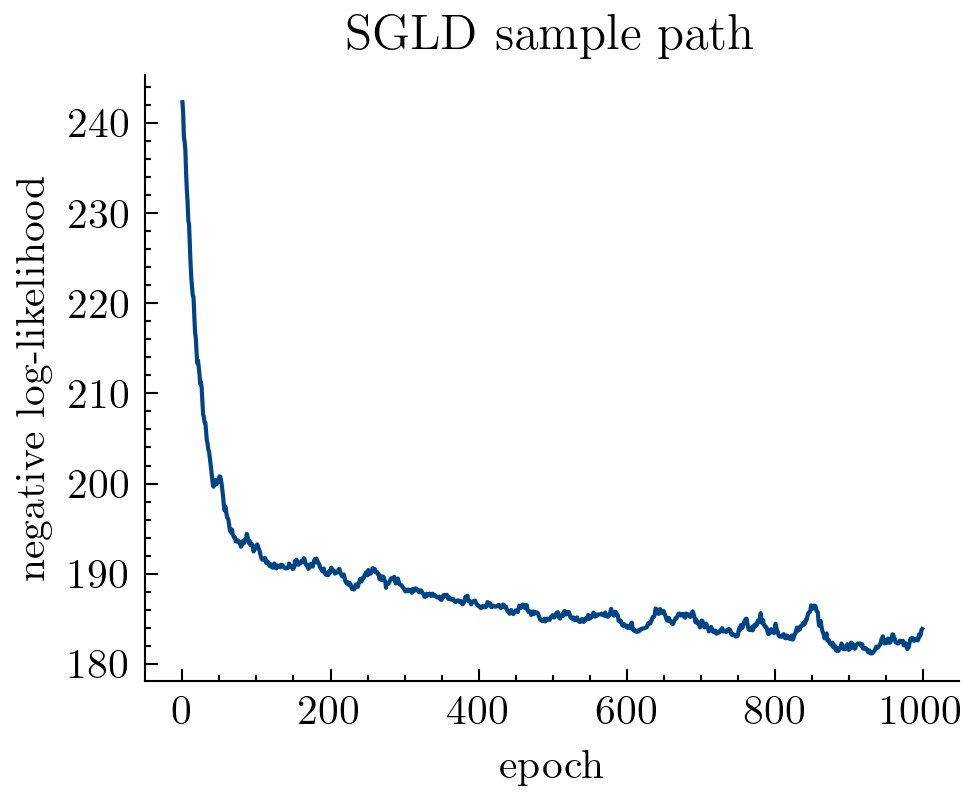

In [11]:
fig, ax = plt.subplots(dpi=300)
ax.plot(loss)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set(xlabel="epoch", ylabel="negative log-likelihood", title="SGLD sample path");
#fig.savefig("figures/sgld_nll.pdf")
plt.show()
#plt.close()

In [12]:
fig.savefig("sgld_nll.pdf")
plt.close()

In [13]:
jax.tree.map(lambda p:p.shape,sgld_samples[0])

{'params': {'layer1': {'bias': (32,), 'kernel': (2, 32)},
  'layer2': {'bias': (64,), 'kernel': (32, 64)},
  'layer3': {'bias': (1,), 'kernel': (64, 1)}}}

# INT 8 Quantization

[Quantization Blog]https://leimao.github.io/article/Neural-Networks-Quantization/

https://proceedings.mlr.press/v162/zhang22ag/zhang22ag.pdf

In [14]:
def quantization(x, s, z, alpha_q, beta_q):
    x_q = jnp.round(1 / s * x + z, decimals=0)
    x_q = jnp.clip(x_q, a_min=alpha_q, a_max=beta_q)
    return x_q.astype(jnp.uint8)


def quantization_int8(x, s, z):
    x_q = quantization(x, s, z, alpha_q=-128, beta_q=127)
    x_q = x_q.astype(jnp.int8)
    return x_q

def dequantization(x_q, s, z):
    # x_q - z might go outside the quantization range.
    x_q = x_q.astype(jnp.int32)
    x = s * (x_q - z)
    x = x.astype(jnp.float16)
    return x


def generate_quantization_constants_scale(alpha, beta, alpha_q, beta_q):
    # Affine quantization mapping
    s = (beta - alpha) / (beta_q - alpha_q)
    return s

def generate_quantization_constants_bias(alpha, beta, alpha_q, beta_q):
    # Affine quantization mapping
    z = jnp.int8((beta * alpha_q - alpha * beta_q) / (beta - alpha))
    return z



In [15]:
def tree_stack(trees):
    return jax.tree.map(lambda *v: jnp.stack(v), *trees)

def tree_unstack(tree):
    leaves, treedef = jax.tree.flatten(tree)
    return [treedef.unflatten(leaf) for leaf in zip(*leaves, strict=True)]

stacked_samples=tree_stack(sgld_samples)
alpha=jax.tree.map(lambda p:jnp.min(p,axis=0),stacked_samples)
beta=jax.tree.map(lambda p:jnp.max(p,axis=0),stacked_samples)
b=8
alpha_q = 0
beta_q = 255
s=jax.tree.map(lambda a,b:generate_quantization_constants_scale(a,b,alpha_q,beta_q),alpha,beta)
z=jax.tree.map(lambda a,b:generate_quantization_constants_bias(a,b,alpha_q,beta_q),alpha,beta)


In [16]:
quantized_stacked_samples=jax.tree.map(lambda x,s,z:quantization(x,s,z,alpha_q,beta_q),stacked_samples,s,z)

In [17]:
jax.tree.map(lambda p:p.shape,quantized_stacked_samples)

{'params': {'layer1': {'bias': (1000, 32), 'kernel': (1000, 2, 32)},
  'layer2': {'bias': (1000, 64), 'kernel': (1000, 32, 64)},
  'layer3': {'bias': (1000, 1), 'kernel': (1000, 64, 1)}}}

In [18]:
jax.tree.map(lambda p:p.shape,stacked_samples)

{'params': {'layer1': {'bias': (1000, 32), 'kernel': (1000, 2, 32)},
  'layer2': {'bias': (1000, 64), 'kernel': (1000, 32, 64)},
  'layer3': {'bias': (1000, 1), 'kernel': (1000, 64, 1)}}}

In [19]:
dequantized_stacked_samples=jax.tree.map(
    lambda x,s,z:dequantization(x,s,z),quantized_stacked_samples,s,z)

In [20]:
jax.tree.map(lambda p:p.shape,dequantized_stacked_samples)

{'params': {'layer1': {'bias': (1000, 32), 'kernel': (1000, 2, 32)},
  'layer2': {'bias': (1000, 64), 'kernel': (1000, 32, 64)},
  'layer3': {'bias': (1000, 1), 'kernel': (1000, 64, 1)}}}

In [21]:
#dequantized_samples=tree_unstack(dequantized_stacked_samples)

In [22]:
jax.tree.map(lambda p,q:jnp.linalg.norm(p-q),dequantized_stacked_samples,stacked_samples)

{'params': {'layer1': {'bias': Array(5.8539877, dtype=float32),
   'kernel': Array(110.42033, dtype=float32)},
  'layer2': {'bias': Array(14.523313, dtype=float32),
   'kernel': Array(129.38638, dtype=float32)},
  'layer3': {'bias': Array(4.7774396, dtype=float32),
   'kernel': Array(20.148054, dtype=float32)}}}

In [23]:
fp32_size=sum(jax.tree.flatten(jax.tree.map(lambda p:p.nbytes,stacked_samples))[0])*1e-6

In [24]:
int8_size=sum(jax.tree.flatten(jax.tree.map(lambda p:p.nbytes,quantized_stacked_samples))[0])*1e-6

In [25]:
print('Tamaño Muestras FP32 : {0:.2f}Mb'.format(fp32_size))
print('Tamaño Muestras INT8 : {0:.2f}Mb'.format(int8_size))

Tamaño Muestras FP32 : 9.09Mb
Tamaño Muestras INT8 : 2.27Mb


# Pruebas de Clasificacion

In [26]:
import numpy as np

params=sgld_samples[-1]
y_pred=np.asarray(model.apply(params, X_test)>0.5)

In [27]:
from matplotlib.colors import ListedColormap
h=0.1
x_min, x_max = X_train[:, 0].min() - .5, X_train[:, 0].max() + .5
y_min, y_max = X_train[:, 1].min() - .5, X_train[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
X_grid = jnp.c_[xx.ravel(), yy.ravel()]
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])


In [28]:
X_grid.shape

(2809, 2)

In [29]:
mean_grid_pred=jax.vmap(model.apply,in_axes=(0,None))(stacked_samples, X_grid).mean(axis=0)
q_mean_grid_pred=jax.vmap(model.apply,in_axes=(0,None))(dequantized_stacked_samples, X_grid).mean(axis=0)


Text(0.5, 1.0, '8-BIT Integer')

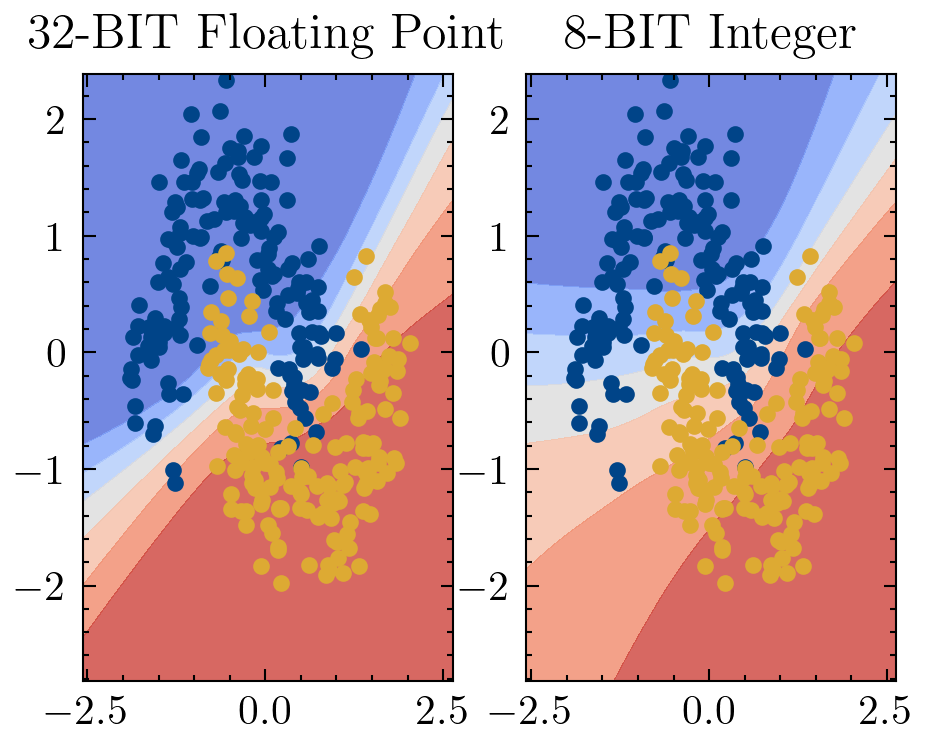

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2,dpi=300)
#fig.suptitle('Class Probabilities')
ax1.contourf(xx, yy, np.array(mean_grid_pred).reshape(xx.shape), cmap="coolwarm", alpha=0.8)
ax1.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color="C0", label="Class 0")
ax1.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color="C1", label="Class 1")
ax1.set_title('32-BIT Floating Point')
#ax1.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
ax2.contourf(xx, yy, np.array(q_mean_grid_pred).reshape(xx.shape), cmap="coolwarm", alpha=0.8)
ax2.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color="C0",label="Class 0")
ax2.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color="C1", label="Class 1")
ax2.set_title('8-BIT Integer')

In [31]:
preds=jax.vmap(model.apply,in_axes=(0,None))(stacked_samples, X_test)

In [32]:
q_preds=jax.vmap(model.apply,in_axes=(0,None))(dequantized_stacked_samples, X_test)

In [33]:
mean_pred=jnp.mean(preds,axis=0)

In [34]:
q_mean_pred=jnp.mean(q_preds,axis=0)

In [38]:
preds.shape

(1000, 330, 1)

In [39]:
y_test.shape

(330,)

In [40]:
from sklearn.metrics import classification_report

print(classification_report(y_test, np.asarray(mean_pred>0.5)))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       153
           1       0.89      0.84      0.86       177

    accuracy                           0.85       330
   macro avg       0.85      0.86      0.85       330
weighted avg       0.86      0.85      0.85       330



In [42]:
from sklearn.metrics import precision_recall_fscore_support

fp32_ensemble=list()
for i in range(preds.shape[0]):
    fp32_ensemble.append(precision_recall_fscore_support(y_test, np.asarray(preds[i]>0.5),average='macro')) 

In [43]:
quantiles=np.quantile(np.asarray(fp32_ensemble)[:,0:3],[0.05,0.5,0.95],axis=0)

In [45]:
print(quantiles)

[[0.8138585457354077 0.8131632879140357 0.8090470723306544]
 [0.8446154029793735 0.8455743879472692 0.8424010873957606]
 [0.8816118131060828 0.8836268970865182 0.881634492463051]]


In [46]:
print(classification_report(y_test, np.asarray(q_mean_pred>0.5)))

              precision    recall  f1-score   support

           0       0.82      0.79      0.80       153
           1       0.82      0.85      0.84       177

    accuracy                           0.82       330
   macro avg       0.82      0.82      0.82       330
weighted avg       0.82      0.82      0.82       330



In [47]:
int8_ensemble=list()
for i in range(q_preds.shape[0]):
    int8_ensemble.append(precision_recall_fscore_support(y_test, np.asarray(q_preds[i]>0.5),average='macro')) 

In [48]:
quantiles=np.quantile(np.asarray(int8_ensemble)[:,0:3],[0.05,0.5,0.95],axis=0)
print(quantiles)

[[0.7809615384615385 0.7620084191868838 0.7490145916175328]
 [0.8257225847707832 0.8192921236291126 0.818121693121693]
 [0.8431161704178872 0.841697130829733 0.8411111111111111]]


In [49]:
from sklearn.metrics import brier_score_loss

fp32_brier=brier_score_loss(y_test, mean_pred)
int8_brier=brier_score_loss(y_test, q_mean_pred)

In [50]:
print('Brier Score FP32 : {0:.4f}'.format(fp32_brier))
print('Brier Score INT8 : {0:.4f}'.format(int8_brier))

Brier Score FP32 : 0.1058
Brier Score INT8 : 0.1098


# Metricas de Muestreo

In [51]:
from kernax import SteinThinning

In [52]:
jax.tree.map(lambda p:p.shape,stacked_samples)

{'params': {'layer1': {'bias': (1000, 32), 'kernel': (1000, 2, 32)},
  'layer2': {'bias': (1000, 64), 'kernel': (1000, 32, 64)},
  'layer3': {'bias': (1000, 1), 'kernel': (1000, 64, 1)}}}

In [53]:
log_probs=jax.vmap(loglikelihood,in_axes=(0,None,None))(stacked_samples['params'],X_test,y_test)

In [54]:
score_fn=jax.grad(loglikelihood)

In [55]:
scores={'params':jax.vmap(score_fn,in_axes=(0,None,None))(stacked_samples['params'],X_test,y_test)}

In [56]:
from kernax.utils import median_heuristic

flatten_stacked_samples=jax.tree.map(lambda p:p.reshape(num_training_steps,-1),stacked_samples)
length_scales=jax.tree.map(lambda p:median_heuristic(p),flatten_stacked_samples)


In [57]:
flatten_scores=jax.tree.map(lambda p:p.reshape(num_training_steps,-1),scores)

In [58]:
from kernax import SteinThinning

stein_fn=jax.tree.map(lambda x,s,l:SteinThinning(x,s,l),flatten_stacked_samples,flatten_scores,length_scales)

In [59]:
indices=jax.tree.map(lambda f:f(500),stein_fn)

In [60]:
thinned_samples=jax.tree.map(lambda x,i:x[i],stacked_samples,indices)

In [ ]:
jax.tree.map(lambda p:p.shape,thinned_samples)

In [61]:
fp32_thinned_size=sum(jax.tree.flatten(jax.tree.map(lambda p:p.nbytes,thinned_samples))[0])*1e-6
print('Tamaño Muestras FP32 Thinned: {0:.2f}Mb'.format(fp32_thinned_size))

Tamaño Muestras FP32 Thinned: 4.55Mb


In [62]:
thinned_preds=jax.vmap(model.apply,in_axes=(0,None))(thinned_samples, X_test)

In [63]:
thinned_ensemble=list()
for i in range(thinned_preds.shape[0]):
    thinned_ensemble.append(precision_recall_fscore_support(y_test, np.asarray(thinned_preds[i]>0.5),average='macro')) 

In [67]:
quantiles=np.quantile(np.asarray(thinned_ensemble)[:,0:3],[0.05,0.5,0.95],axis=0)

In [68]:
thinned_mean_pred=jnp.mean(thinned_preds,axis=0)

In [69]:
print(quantiles)

[[0.7979307782472378 0.7840284701451201 0.7807561009264735]
 [0.8327777777777778 0.8317824304863188 0.8300783405053515]
 [0.8641553764156656 0.8623961448986374 0.8602899282861787]]


In [70]:

print(classification_report(y_test, np.asarray(thinned_mean_pred>0.5)))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       153
           1       0.86      0.84      0.85       177

    accuracy                           0.84       330
   macro avg       0.84      0.84      0.84       330
weighted avg       0.84      0.84      0.84       330



In [71]:
t_mean_grid_pred=jax.vmap(model.apply,in_axes=(0,None))(thinned_samples, X_grid).mean(axis=0)

In [72]:
t_mean_grid_pred.shape

(2809, 1)

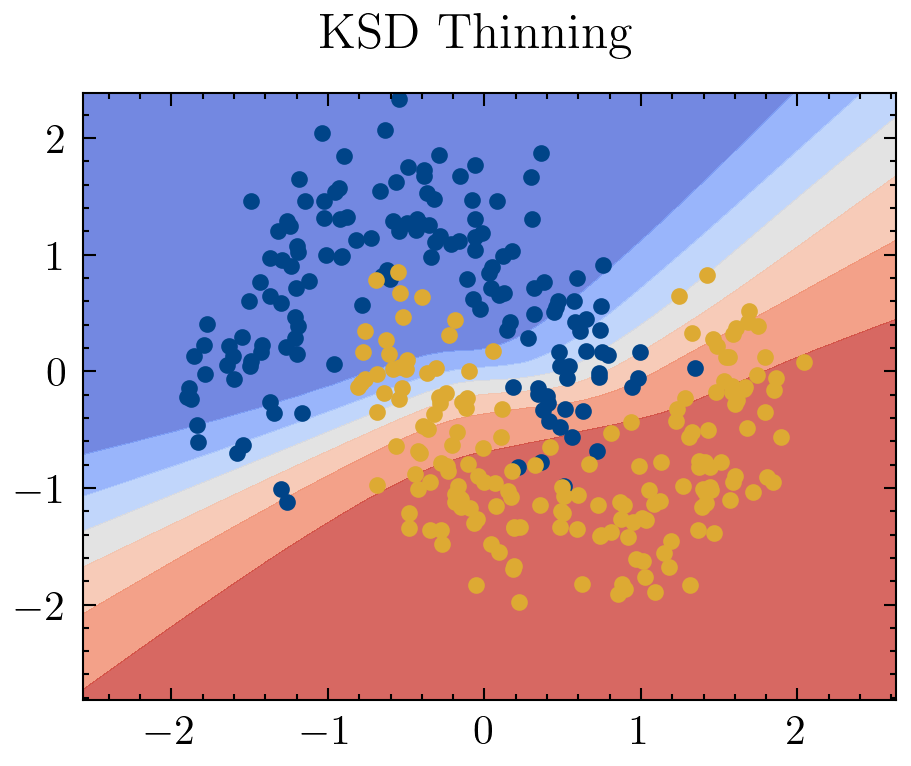

In [73]:
fig, ax = plt.subplots(1, 1,dpi=300)
fig.suptitle('KSD Thinning')
ax.contourf(xx, yy, np.array(t_mean_grid_pred).reshape(xx.shape), cmap="coolwarm", alpha=0.8)
ax.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color="C0", label="Class 0")
ax.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color="C1", label="Class 1")

# Thinning + Quantization

In [74]:
alpha=jax.tree.map(lambda p:jnp.min(p,axis=0),thinned_samples)
beta=jax.tree.map(lambda p:jnp.max(p,axis=0),thinned_samples)
b=8
alpha_q = 0
beta_q = 255
s=jax.tree.map(lambda a,b:generate_quantization_constants_scale(a,b,alpha_q,beta_q),alpha,beta)
z=jax.tree.map(lambda a,b:generate_quantization_constants_bias(a,b,alpha_q,beta_q),alpha,beta)

In [75]:
quantized_thinned_samples=jax.tree.map(lambda x,s,z:quantization(x,s,z,alpha_q,beta_q),thinned_samples,s,z)

In [76]:
int8_thinned_size=sum(jax.tree.flatten(jax.tree.map(lambda p:p.nbytes,quantized_thinned_samples))[0])*1e-6
print('Tamaño Muestras INT8 Thinned: {0:.2f}Mb'.format(int8_thinned_size))

Tamaño Muestras INT8 Thinned: 1.14Mb


In [77]:
dequantized_thinned_samples=jax.tree.map(
    lambda x,s,z:dequantization(x,s,z),quantized_thinned_samples,s,z)

In [78]:
quantized_thinned_preds=jax.vmap(model.apply,in_axes=(0,None))(dequantized_thinned_samples, X_test)
quantized_thinned_mean_pred=jnp.mean(quantized_thinned_preds,axis=0)

In [79]:
quantized_thinned_ensemble=list()
for i in range(quantized_thinned_preds.shape[0]):
    quantized_thinned_ensemble.append(precision_recall_fscore_support(y_test, np.asarray(quantized_thinned_preds[i]>0.5),average='macro')) 

/home/shernandez/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shernandez/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shernandez/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shernan

In [80]:
quantiles=np.quantile(np.asarray(quantized_thinned_ensemble)[:,0:3],[0.05,0.5,0.95],axis=0)

In [81]:
print(quantiles)

[[0.7605624883902785 0.6586130497396698 0.6323001918080329]
 [0.8202173913043478 0.7998781433477347 0.8018698001543871]
 [0.8480359925748212 0.840810900631439 0.8399063918388652]]


In [82]:
jax.tree.map(lambda p: p.shape,quantized_thinned_preds)

(500, 330, 1)

In [83]:
print(classification_report(y_test, np.asarray(quantized_thinned_mean_pred>0.5)))

              precision    recall  f1-score   support

           0       0.87      0.71      0.78       153
           1       0.78      0.90      0.84       177

    accuracy                           0.82       330
   macro avg       0.82      0.81      0.81       330
weighted avg       0.82      0.82      0.81       330



In [84]:
qt_mean_grid_pred=jax.vmap(model.apply,in_axes=(0,None))(dequantized_thinned_samples, X_grid).mean(axis=0)

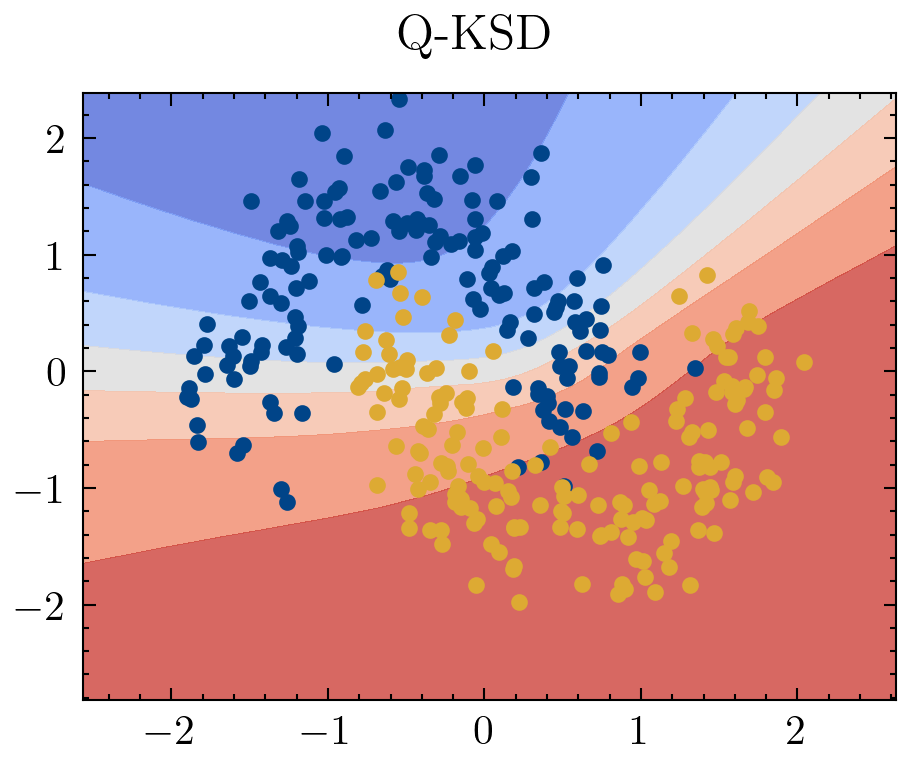

In [85]:
fig, ax = plt.subplots(1, 1,dpi=300)
fig.suptitle('Q-KSD')
ax.contourf(xx, yy, np.array(qt_mean_grid_pred).reshape(xx.shape), cmap="coolwarm", alpha=0.8)
ax.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color="C0", label="Class 0")
ax.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color="C1", label="Class 1")

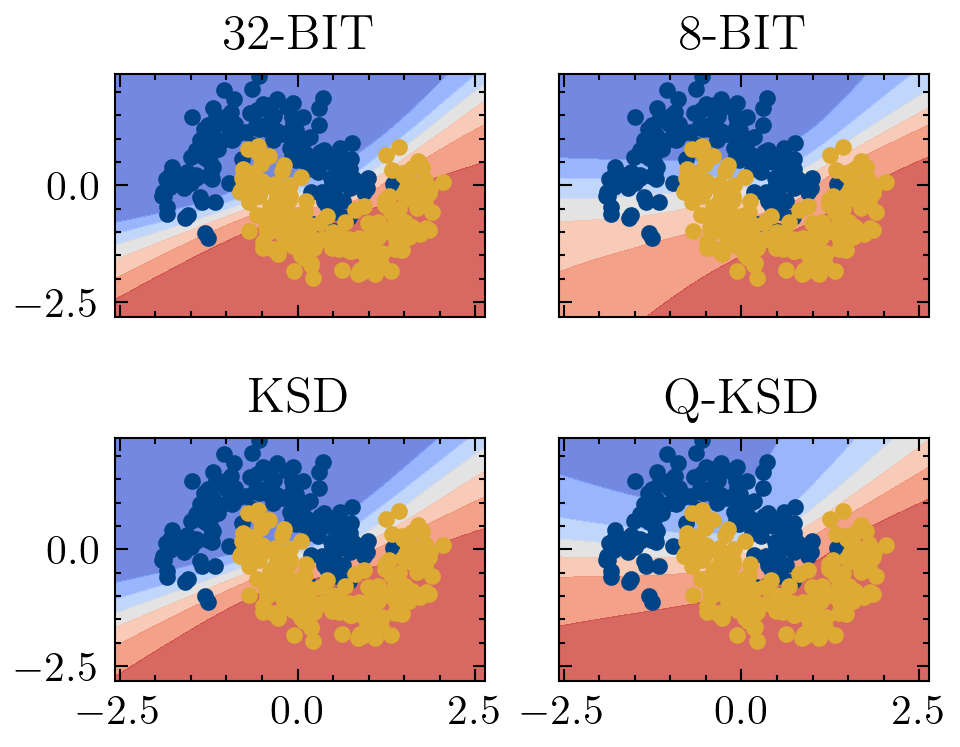

In [86]:
fig, ( (ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2,dpi=300, sharey=True,sharex=True)
#fig.suptitle('Class Probabilities')
ax1.contourf(xx, yy, np.array(mean_grid_pred).reshape(xx.shape), cmap="coolwarm", alpha=0.8)
ax1.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color="C0", label="Class 0")
ax1.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color="C1", label="Class 1")
ax1.set_title('32-BIT')
ax1.autoscale(tight=True)
#ax1.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
ax2.contourf(xx, yy, np.array(q_mean_grid_pred).reshape(xx.shape), cmap="coolwarm", alpha=0.8)
ax2.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color="C0",label="Class 0")
ax2.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color="C1", label="Class 1")
ax2.set_title('8-BIT')
ax2.sharex(ax1)
ax2.sharey(ax1)
ax2.autoscale(tight=True)
ax3.contourf(xx, yy, np.array(t_mean_grid_pred).reshape(xx.shape), cmap="coolwarm", alpha=0.8)
ax3.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color="C0", label="Class 0")
ax3.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color="C1", label="Class 1")
ax3.set_title('KSD')
ax3.sharex(ax1)
ax3.sharey(ax1)
ax3.autoscale(tight=True)
ax4.contourf(xx, yy, np.array(qt_mean_grid_pred).reshape(xx.shape), cmap="coolwarm", alpha=0.8)
ax4.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color="C0", label="Class 0")
ax4.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color="C1", label="Class 1")
ax4.set_title('Q-KSD')
ax4.sharex(ax1)
ax4.sharey(ax1)
ax4.autoscale(tight=True)
plt.subplots_adjust(hspace=0.5)

In [87]:
fig.savefig("sgld_class_probs.pdf")
plt.close()

In [88]:
ksd_fp32_brier=brier_score_loss(y_test, thinned_mean_pred)
ksd_int8_brier=brier_score_loss(y_test, quantized_thinned_mean_pred)

In [89]:
print('Brier Score KSD FP32 : {0:.4f}'.format(ksd_fp32_brier))
print('Brier Score KSD INT8 : {0:.4f}'.format(ksd_int8_brier))

Brier Score KSD FP32 : 0.1156
Brier Score KSD INT8 : 0.1292
